# Nesterov testing

In [1]:
from scipy.linalg import svd as SCIPYsvd

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from copy import deepcopy
from sklearn.datasets import make_regression as Make_reg # default is 100 samples, 100 features
from sklearn.datasets import make_classification as Make_class # default is 100 samples, 20 features, 2 classes
from sklearn.model_selection import train_test_split as split

In [4]:
rng = np.random.default_rng()

In [21]:
p = int(1e3)
q = p+50

In [22]:
A = rng.random((q,p))

In [23]:
np.shape(A)

(1050, 1000)

In [25]:
np.max(np.linalg.svd(A@A.T)[1])

263454.93862925435

$h(w)$: Sigmoid function:

$$\frac{1}{1 + e^{-\langle x, w \rangle}}$$

$f_{\text{LOG}}(w)$: negative log liklihood function:

$$-\frac{1}{k}  \sum_{i=1}^k \bigg( y_k \log(h(w)) + (1 - y_k) \log(1 -h(w))\bigg) $$

Explicitly:

$$\frac{1}{k} \sum_{i=1}^k \Bigg( -y_k \log\bigg(\frac{1}{1 + e^{-\langle x_k, w \rangle}}\bigg) - (1 - y_k) \log\bigg(1 - \frac{1}{1 + e^{-\langle x_k, w \rangle}}\bigg) \Bigg)$$

$g_{\text{LOG}}(w) = f'_{\text{LOG}}(w)$: gradient function of negative log liklihood:

$$ \langle h(w) - y, x \rangle $$

Explicitly: (fix here - check definition of dot product vs matrix mult.)

$$ \Bigg\langle \frac{1}{1 + e^{-\langle x, w \rangle}} - y, x \Bigg\rangle = \frac{1}{k} \sum_{i=1}^k  x_k \Bigg( \frac{1}{1 + e^{-\langle x_k, w \rangle}} - y_k \Bigg) $$

A note on the data:

$x$ is an $m \times n$ matrix of $m$ samples and $n$ features. So it is a dataset in $\mathbb{R}^n$.

$y$ is a $m \times 1$ vector with a binary classifier for each sample.

$w$ is a $1 \times n$ array.

### Defining Functions

In [1]:
def ren(x): return range(len(x)) # a function for plotting iterates of a list
def sigmoid(w, x): # a basic sigmoid function
    denom = 1 + np.exp( - np.dot(x,w) )
    return 1 / denom
def normalise(x): # normalises the input data to values between 0 and 1
    mins = np.min(x, axis = 0)
    maxs = np.max(x, axis = 0)
    rng = maxs - mins
    return  1 - (maxs- x)/rng
def f_Log(w, x, y): # neg log likli func: see LaTeX above
    sig = sigmoid(w,x)
    step1 = y*np.log(sig + 1e-300)
    step2 = (1-y)*np.log(1 - sig + 1e-300)
    return np.mean(-step1 - step2)
def g_Log(w, x, y): # simplified gradient function, essentially just x(h(w) - y): see LaTeX above
    sig = sigmoid(w,x)
    inner = sig - y
    return np.dot(inner, x)
def GD_Log(w, lam, x, y):
    return w - lam*g_Log(w,x,y)
def predict(w, x):
    sig = sigmoid(w, x)
    return np.squeeze( np.where(sig >= 0.5, 1, 0) )
def classify(w, x_Te, y_Te):
    return sum( predict(w, x_Te) == y_Te ) / len(x_Te)

### Make classification dataset

#### For generating new classification dataset

In [3]:
my_classes = Make_class(n_samples=1000)
ones_array = np.array([[1]*len(my_classes[0])])
aug_data = np.concatenate((ones_array.T, normalise(my_classes[0])), axis = 1)
xTrain, xTest, yTrain, yTest = split( aug_data, my_classes[1], test_size = 0.1)
w_copy = np.random.rand(len(xTrain[0]))

In [7]:
v = np.zeros(len(u)-2)
for i in range(len(v)):
    v[i] = (1-u[i])/u[i+2]
v

array([ 0.61803399,  0.        , -0.22475669, -0.36223693, -0.45655448,
       -0.52573615, -0.57883538, -0.62096647, -0.65525839, -0.68374126,
       -0.70779348, -0.72838566, -0.74622198, -0.76182632, -0.77559673,
       -0.78784137, -0.79880255, -0.80867359, -0.8176106 , -0.8257411 ,
       -0.8331703 , -0.83998575, -0.84626098, -0.85205815, -0.8574302 ,
       -0.8624225 , -0.86707417, -0.87141908, -0.87548678, -0.8793031 ,
       -0.88289076, -0.88626981, -0.889458  , -0.89247114, -0.89532332,
       -0.89802716, -0.90059397, -0.90303397, -0.90535636, -0.90756947,
       -0.90968087, -0.91169744, -0.91362545, -0.91547062, -0.91723821,
       -0.91893302, -0.92055947, -0.92212162])

In [4]:
error = 1e-6
initialTime = time.time()
w = w_copy
grad = g_Log(w, xTrain, yTrain)
gradNorm = np.linalg.norm(grad)
gradientValList = [gradNorm]
functionValList = [f_Log(w, xTrain, yTrain)]
timeList = [time.time() - initialTime]
predList = [classify(w, xTest, yTest)]
lam0 = 1
L = np.max( np.linalg.svd(xTrain @ xTrain.T)[1] )
y0 = w

In [14]:
w

array([0.17781865, 0.90718842, 0.37323973, 0.09072745, 0.15057946,
       0.89318578, 0.2128802 , 0.32075733, 0.61203396, 0.04821536,
       0.80712189, 0.49297295, 0.99324479, 0.43965218, 0.09629294,
       0.33619584, 0.90060585, 0.05046557, 0.72088914, 0.8734027 ,
       0.47901898])

In [11]:
lam = 0.5*(1 + np.sqrt(1 + 4*lam0**2))
lam

1.618033988749895

In [12]:
gamma = (1 - lam0)/lam
gamma

0.0

In [13]:
y1 = w - grad/L
y1

array([0.0919681 , 0.86731428, 0.32676137, 0.03951221, 0.10720757,
       0.85156937, 0.18204921, 0.2839014 , 0.56775651, 0.01111193,
       0.75416381, 0.45537999, 0.95493025, 0.40017689, 0.05972466,
       0.29474969, 0.86704518, 0.01015134, 0.67552072, 0.83277728,
       0.43691401])

In [15]:
w = (1 - gamma)*y1 + gamma*y0
w

array([0.0919681 , 0.86731428, 0.32676137, 0.03951221, 0.10720757,
       0.85156937, 0.18204921, 0.2839014 , 0.56775651, 0.01111193,
       0.75416381, 0.45537999, 0.95493025, 0.40017689, 0.05972466,
       0.29474969, 0.86704518, 0.01015134, 0.67552072, 0.83277728,
       0.43691401])

In [ ]:
y0 = y1

<ipython-input-2-403024de6bf8>:3: RuntimeWarning: overflow encountered in exp
  denom = 1 + np.exp( - np.dot(x,w) )


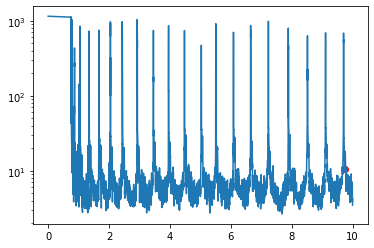

In [18]:

while gradNorm > error:
    lam = 0.5*(1 + np.sqrt(1 + 4*lam0**2))
    gamma = (1 - lam0)/lam
#     print('gamma', gamma)
    y1 = w - grad/L
    w = (1 - gamma)*y1 + gamma*y0
    y0 = y1
    lam0 = lam
    w = GD_Log(w, lam, xTrain, yTrain)
    grad = g_Log(w, xTrain, yTrain)
    gradNorm = np.linalg.norm(grad)
    gradientValList.append(gradNorm)
    functionValList.append(f_Log(w, xTrain, yTrain))
    timeList.append(time.time() - initialTime)
    predList.append(classify(w,xTest,yTest))
    if timeList[-1] > 10:
        break
plt.scatter(timeList[- (np.argmax(predList[::-1])+1)], gradientValList[- (np.argmax(predList[::-1])+1)], c= 'r')
plt.plot(timeList, gradientValList)
plt.yscale('log')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (11711,) and (9559,)

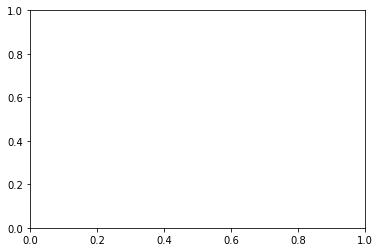

In [19]:
plt.plot(timeList, functionValList)
plt.show()

In [8]:
predList[-1]

0.94

In [7]:
np.argmax(predList)

161